In [480]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
import torch.nn as nn
import torch
from torch import nn
from itertools import product
from monk_helpers import CV,SEED
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import time




Create reproducible results

In [481]:
torch.manual_seed(SEED)
np.random.seed(SEED)
gen = torch.Generator().manual_seed(SEED)
SEEDS = list(range(40,46))


In [482]:
# Datasets Path
TR_PATH_1 = "./monks/datasets/monks-1.train"
TS_PATH_1 = "./monks/datasets/monks-1.test"
# Datasets Path
TR_PATH_2 = "./monks/datasets/monks-2.train"
TS_PATH_2 = "./monks/datasets/monks-2.test"
# Datasets Path
TR_PATH_3 = "./monks/datasets/monks-3.train"
TS_PATH_3 = "./monks/datasets/monks-3.test"

In [483]:

def plot_graph(train_losses,losses,epochs,title):
    num_epochs = list(range(0, epochs))  
    # Plotting
    plt.plot(num_epochs, train_losses, label=' Training',linestyle='-')
    plt.plot(num_epochs, losses, label=title+' MSE',linestyle='--')

    plt.title('Training and '+title+' Losses Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

In [484]:

def plot_graph_accuracy(train_accuracies, accuracies, epochs):
    #TODO mettere "-" e "--" per train e test    

    num_epochs = list(range(0, epochs))
    print(len(num_epochs))
    # Plotting
    plt.plot(num_epochs, train_accuracies, label='Training Accuracy',linestyle='-')
    plt.plot(num_epochs, accuracies, label='Test Accuracy',linestyle='--')

    plt.title('Training and Test Accuracies Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [485]:
class Net(nn.Module):

  def __init__(self, input_size, units, output_size):
    super().__init__()
    self.units = units

    self.l1 = nn.Linear(input_size, units)
    self.l2 = nn.Linear(units, output_size)

  def forward(self, x):
    out = torch.tanh(self.l1(x))
    out = torch.sigmoid(self.l2(out))
    return out


def reset_weights(net):
  for param in net.parameters():
    torch.nn.init.uniform_(param, a=-0.7, b=0.7)

In [486]:
def read_ds(path):
  """
  parse CSV data set and
  returns a tuple (input, target)
  """
  names = ['class', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id']
  data = pd.read_csv(path, dtype=object, delim_whitespace=True, header=None, skipinitialspace=True, names=names)

  X = data.drop(['class','id'], axis=1)
  X = pd.get_dummies(X).astype(float).to_numpy()
  y = data.drop(['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'id'], axis=1)
  y = y.astype(float).to_numpy()


  return np.concatenate((y, X), axis=1)

In [487]:
class ToleranceStopper:
  def __init__(self, patience=1, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_training_loss = np.inf

  def tol_stop(self, training_loss):
    if training_loss > (self.min_training_loss - self.min_delta):
      self.counter +=1
      if self.counter >= self.patience:
        return True
    else: 
      self.counter = 0
    if training_loss < self.min_training_loss:
      self.min_training_loss = training_loss
    
    return False

In [488]:
def Padding(validation_losses_fold,train_losses_fold):
    max_epochs = max(map(len, validation_losses_fold))

    for validation_loss_arr in validation_losses_fold:
        while len(validation_loss_arr) < max_epochs:
            validation_loss_arr.append(validation_loss_arr[-1])

    for train_loss_arr in train_losses_fold:
      while len(train_loss_arr) < max_epochs:
            train_loss_arr.append(train_loss_arr[-1])

    print(len(validation_losses_fold))
    return validation_losses_fold,train_losses_fold

In [489]:
def Mean(validation_avg_loss_fold,train_losses_fold):
    max_epochs = max(map(len, validation_avg_loss_fold))
    validation_avg_loss = []
    train_avg_loss = []
    
    for i in range(0,max_epochs):
        temp_loss = 0
        for j in range(0,len(validation_avg_loss_fold)):
            temp_loss += validation_avg_loss_fold[j][i]
        validation_avg_loss.append(temp_loss)

    for i in range(0,max_epochs):
        temp_loss = 0
        for j in range(0,len(train_losses_fold)):
            temp_loss += train_losses_fold[j][i]
        train_avg_loss.append(temp_loss)
    
    return validation_avg_loss,train_avg_loss
    

    

In [490]:
def fit_model(input_size,hidden_size,output_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,testloader):
    # Init the neural network
    network = Net(input_size, hidden_size, output_size)
    network.apply(reset_weights) #reset weights with random initialization
    # Use the GPU, if possible
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"
      if torch.cuda.device_count() > 1:
        network = nn.DataParallel(network)
    network.to(device)

    optimizer = opt(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    

    
    train_losses = []
    test_losses = []


    
    epoch_train_accuracies = []
    epoch_test_accuracies = []

    tolerance_stopper = ToleranceStopper(patience=40, min_delta=1e-5)

    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      # Print epoch
      print(f'Starting epoch {epoch+1}')

      # Set current loss and accuracy value for train
      train_loss = 0.0
      epoch_train_accuracy = 0.0

      # Set current loss and accuracy value for test
      test_loss = 0.0
      epoch_test_accuracy = 0.0


      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, 1:].to(torch.float32).to(device)
        targets = data[:, [0]].to(torch.float32).to(device)

        # Zero the gradients
        optimizer.zero_grad() 

        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)

        # Update accuracy
        for output, target in zip(outputs, targets):
          output = 0 if output.item() < 0.5 else 1
          if output == target.item():
            epoch_train_accuracy += 1

      # Print loss values
      epoch_train_loss = train_loss / len(trainloader.sampler)
      train_losses.append(epoch_train_loss)

      epoch_train_accuracy /= len(trainloader.sampler)

      epoch_train_accuracies.append(epoch_train_accuracy)

      
      with torch.no_grad():
        # Iterate over the testing data and generate predictions
        for i, data in enumerate(testloader, 0):

          inputs = data[:, 1:].to(torch.float32).to(device)
          targets = data[:, [0]].to(torch.float32).to(device)
        
          outputs = network(inputs)

          loss = loss_function(outputs, targets)
          
          test_loss += loss.item() * inputs.size(0)
          # Update accuracy
          for output, target in zip(outputs, targets):
            output = 0 if output.item() < 0.5 else 1
            if output == target.item():
              epoch_test_accuracy += 1

        epoch_test_loss = test_loss / len(testloader.sampler)    
        test_losses.append(epoch_test_loss)


        
        epoch_test_accuracy /= len(testloader.sampler)

        epoch_test_accuracies.append(epoch_test_accuracy)
        
        print(epoch_test_loss)
        if tolerance_stopper.tol_stop(epoch_test_loss):
          print("Early stopping: ",epoch)
          break

    plot_graph(train_losses,test_losses,epoch+1,"test")
    plot_graph_accuracy(epoch_train_accuracies,epoch_test_accuracies,epoch+1)

    return network,train_losses[-1],test_losses[-1]


In [491]:
def k_fold_model(input_size,hidden_size,output_size,learning_rate,momentum,weight_decay,opt,epochs,trainloader,loss_function,validationloader):
    
    # Init the neural network
    network = Net(input_size, hidden_size, output_size)
    network.apply(reset_weights) #reset weights with random initialization
    
    optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)


    tolerance_stopper = ToleranceStopper(patience=40, min_delta=1e-5)
    train_losses = []
    validaition_losses = []
    # Run the training loop for defined number of epochs
    for epoch in range(0, epochs):

      # Print epoch
      #print(f'Starting epoch {epoch+1}')

      # Set current loss value
      train_loss = 0.0
      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs = data[:, 1:].to(torch.float32)
        targets = data[:, [0]].to(torch.float32)

        # Zero the gradients
        optimizer.zero_grad() 
        
        # Perform forward pass
        outputs = network(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        train_loss += loss.item() * inputs.size(0)

        #print("loss per item", loss.item())
        #print("inputs size",inputs.size(0))

        # Print loss values
      #print("train loaders length",len(trainloader.sampler.indices))

      avg_train_loss = train_loss / len(trainloader.sampler)    
      train_losses.append(avg_train_loss) 
      #print(f'Training loss: {avg_train_loss}')
      # Print about testing
      #print('Starting validation')

      # Evaluationfor this fold
      valid_loss = 0.0 
      with torch.no_grad():
        # Iterate over the validation data and generate predictions
        for i, data in enumerate(validationloader, 0):

          # Get inputs
          inputs = data[:, 1:].to(torch.float32)
          targets = data[:, [0]].to(torch.float32)
          
          # Generate outputs
          outputs = network(inputs)

          loss = loss_function(outputs, targets)

          # Calculate loss
          valid_loss += loss.item() * inputs.size(0)
          #print("loss per item", loss.item())
          #print("inputs size",inputs.size(0))
        
        #print("validation loaders length",len(validationloader.sampler.indices))

        avg_valid_loss = valid_loss / len(validationloader.sampler) #used to find the best parameters of the model
        validaition_losses.append(avg_valid_loss)
        # Early stopping
        if tolerance_stopper.tol_stop(avg_valid_loss):
          print("Early stopping:", epoch)
          break
        # Print validation results
        #print(f'Validation loss: {avg_valid_loss:.4f}')


    '''if(retrain == True):
      plot_graph(train_losses,validaition_losses,epoch,"validation")'''
    return avg_valid_loss,avg_train_loss,validaition_losses,train_losses


In [492]:
def execute_folds(kfold,dataset,batch_size,input_size, hidden_size, output_size, learning_rate, epochs,
    loss_function, momentum, opt, weight_decay):

    validation_avg_loss_fold = 0
    train_avg_loss_fold = 0
    validation_losses_fold = []
    train_losses_fold = []
    num_iterations = 0
    current_config = {
        'input_size': input_size,
        'hidden_size': hidden_size,
        'output_size': output_size,
        'learning_rate': learning_rate,
        'epochs': epochs,
        'momentum': momentum,
        'opt': opt,
        'weight_decay': weight_decay,
        "batch_size":batch_size,
        "loss_function":loss_function
    }
 
    for fold, (train_ids, val_ids) in enumerate(kfold.split(np.zeros(len(dataset)),dataset[:, 0])):

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids, gen) 
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids, gen) 
        # Print
        #print(f'FOLD {fold}')

        #print('--------------------------------')
        # Define data loaders for training and testing data in this fold
        
        trainloader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=batch_size, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                        dataset,
                        batch_size=batch_size, sampler=validation_subsampler)    
        

        validation_loss,train_loss,validation_losses,train_losses = k_fold_model(learning_rate=learning_rate,epochs=epochs,hidden_size=hidden_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                    ,opt=opt,output_size=output_size,trainloader=trainloader,weight_decay=weight_decay,validationloader=validationloader)   
        validation_avg_loss_fold  += validation_loss
        train_avg_loss_fold += train_loss
        validation_losses_fold.append(validation_losses)
        train_losses_fold.append(train_losses)

        num_iterations += 1


    #validation and train average over all folds
    validation_avg_loss_fold /= num_iterations
    train_avg_loss_fold /= num_iterations
    
    validation_losses_fold,train_losses_fold = Padding(validation_losses_fold,train_losses_fold)

    validation_losses_mean, train_losses_mean = Mean(validation_losses_fold, train_losses_fold)
    
    plot_graph(train_losses_mean,validation_losses_mean,len(validation_losses),"validation") 


    return (validation_avg_loss_fold,train_avg_loss_fold,current_config)

function that executes the folds for each combination of parameters

In [493]:
def dogridsearch(dataset_train_part,params_grid,output_size,input_size,seeds):
    
    dataset = dataset_train_part
    # Set fixed random number seed
    loss_function = nn.MSELoss()

    # Define the K-fold Cross Validator
    kfold = CV 
    
    # K-fold Cross Validation model evaluation
    best_params = None

    actual_it = 0
    total_iterations = len(params_grid["epochs"]) * len(params_grid["optimizer"]) * len(params_grid["hidden_size"]) * len(params_grid["learning_rate"]) * len(params_grid["batch_size"]) * len(params_grid["weight_decay"]) * len(params_grid["momentum"]) 


    configurations = []

    for epochs, opt, hidden_size, learning_rate, batch_size, weight_decay, momentum in product(params_grid["epochs"],params_grid["optimizer"], params_grid["hidden_size"], params_grid["learning_rate"], params_grid["batch_size"], params_grid["weight_decay"], params_grid["momentum"]):
        #print the actual percentage of the grid search
        print(f'Actual iter {(actual_it/total_iterations)*100}%')
        for seed in seeds:
            print("Working with seed:",seed)
            torch.manual_seed(seed)
            (validation_avg_loss_fold,train_avg_loss_fold,current_config) = execute_folds(kfold=kfold,dataset=dataset,learning_rate=learning_rate,epochs=epochs,hidden_size=hidden_size,input_size=input_size,loss_function=loss_function,momentum=momentum
                                                            ,opt=opt,output_size=output_size,weight_decay=weight_decay,batch_size=batch_size)
            configurations.append((validation_avg_loss_fold, train_avg_loss_fold,current_config))
        
        actual_it += 1

    val_mse = []
    train_mse = []
    #best 
    for conf_val in configurations:
        val_mse.append(conf_val[0])
        train_mse.append(conf_val[1])
        if best_params is None or conf_val[0] < best_params[0]:
                current_config = conf_val[2]
                best_params = (conf_val[0],conf_val[1]
                ,current_config['learning_rate'], current_config['epochs'],current_config["loss_function"],current_config['hidden_size'],current_config['momentum'],current_config['opt'],
                current_config['weight_decay'],
                current_config['batch_size'])

    print("TRAIN MEAN MSE",np.mean(train_mse))
    print("TRAIN STD",np.std(train_mse))
    print("VALIDATION MEAN MSE",np.mean(val_mse))
    print("VALIDATION STD",np.std(val_mse))

    return best_params

test the created model and plot training/test error

In [494]:
def train_test_model(dataset_train_part,dataset_test_part,best_params,seeds):

    train_subsampler = torch.utils.data.SubsetRandomSampler(range(len(dataset_train_part)), gen)

    trainloader = torch.utils.data.DataLoader(
                        dataset_train_part, 
                        batch_size=best_params[9], sampler=train_subsampler)

    test_subsampler =  torch.utils.data.SubsetRandomSampler(range(len(dataset_test_part)), gen)
    testloader = torch.utils.data.DataLoader(
                        dataset_test_part, 
                        batch_size=best_params[9], sampler=test_subsampler)
    train_error_seed = []
    test_error_seed = []
    for seed in seeds:
        # Start the timer
        start = time.time()
        print("Working with seed:",seed)
        torch.manual_seed(seed)
        best_net,train_error,test_error = fit_model(learning_rate=best_params[2],epochs=best_params[3],hidden_size=best_params[5],input_size=17,loss_function=best_params[4],
                        momentum=best_params[6],opt=best_params[7],output_size=1,trainloader=trainloader,weight_decay=best_params[8],testloader=testloader) 
        train_error_seed.append(train_error)
        test_error_seed.append(test_error)
        end = time.time()
        print("Refit Time: {:.2f} seconds".format(end - start))


    print("TRAIN MEAN MSE",np.mean(train_error_seed))
    print("TRAIN STD",np.std(train_error_seed))
    print("TEST MEAN MSE",np.mean(test_error_seed))
    print("TEST STD",np.std(test_error_seed))

    return best_net

Actual iter 0.0%
Working with seed: 40
Early stopping: 148
Early stopping: 128
Early stopping: 346
5


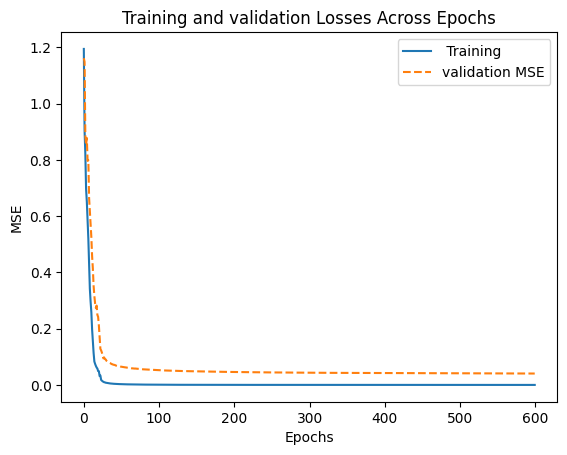

Working with seed: 41
Early stopping: 167
Early stopping: 56
Early stopping: 113
Early stopping: 169
Early stopping: 104
5


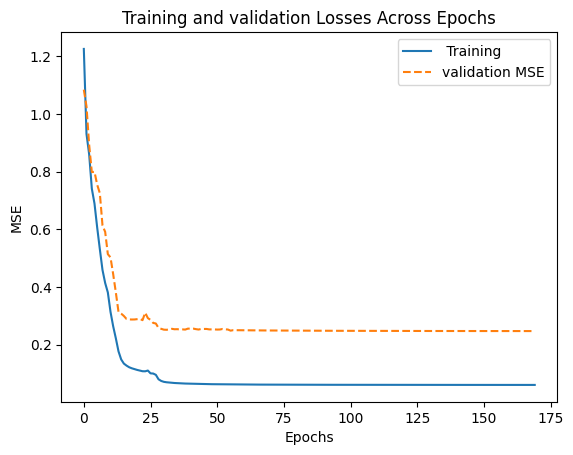

Working with seed: 42
Early stopping: 386
Early stopping: 301
Early stopping: 62
Early stopping: 124


KeyboardInterrupt: 

In [495]:
input_size = 17  
output_size = 1
params_grid_general = {
    "hidden_size": [3, 4, 5],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0,0.001,0.01],
    "momentum": [0,0.1,0.4,0.7,0.8],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],


}


params_grid = {
    "hidden_size": [4],
    "learning_rate": [0.8],
    "batch_size": [4],
    "weight_decay": [0],
    "momentum": [0.5],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],

}
    

dataset_train_part = read_ds(TR_PATH_1)
dataset_test_part = read_ds(TS_PATH_1)

dataset = dataset_train_part



best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size,seeds = SEEDS)
        




monk 1:
Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.0022038360655424185, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)

In [475]:
#Best parameters found
print(f"Best hidden size: {best_params[5]} \nBest learning rate: {best_params[2]} \nBest batch size: {best_params[9]} \nBest weight decay: {best_params[8]} \nBest momentum: {best_params[6]}")

print(best_params)

Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.0026729325915172616, 0.000771210098767305, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)


Working with seed: 40
Starting epoch 1
0.20016394752181238
Starting epoch 2
0.21375142275873157
Starting epoch 3
0.18955250068015797
Starting epoch 4
0.19179076580675664
Starting epoch 5
0.18326086816550405
Starting epoch 6
0.1758259801125085
Starting epoch 7
0.1715797684715923
Starting epoch 8
0.15565444784307922
Starting epoch 9
0.14009567207432594
Starting epoch 10
0.11047528765414392
Starting epoch 11
0.08821280698962423
Starting epoch 12
0.08141282969316105
Starting epoch 13
0.0699229881553307
Starting epoch 14
0.06996761582289494
Starting epoch 15
0.05888603313441207
Starting epoch 16
0.043335342360444846
Starting epoch 17
0.015483516687069184
Starting epoch 18
0.008476337938056397
Starting epoch 19
0.005785499436401382
Starting epoch 20
0.004616516876181036
Starting epoch 21
0.003982399645017857
Starting epoch 22
0.0034021357782034168
Starting epoch 23
0.003037234954616805
Starting epoch 24
0.0026806804944499163
Starting epoch 25
0.0024217710673568676
Starting epoch 26
0.0022311

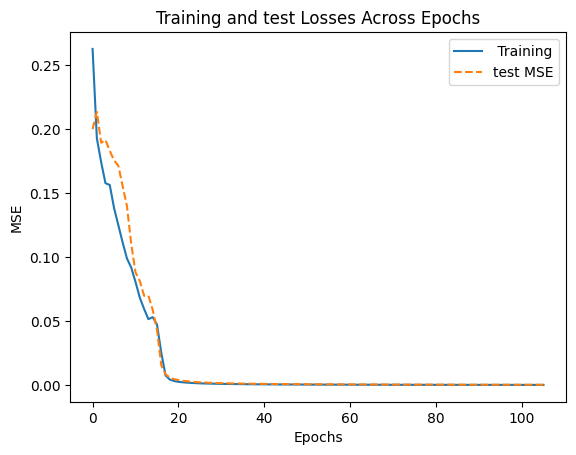

106


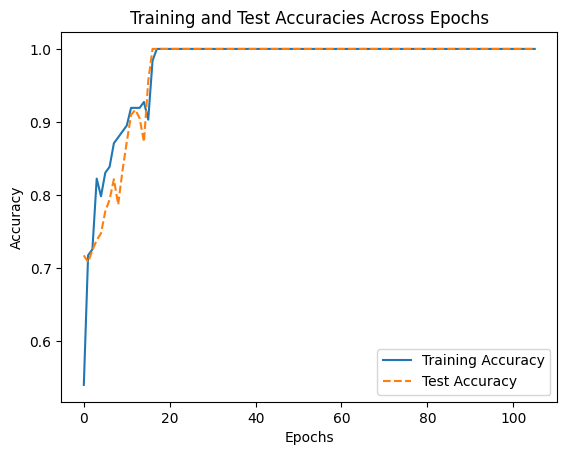

Refit Time: 7.17 seconds
Working with seed: 41
Starting epoch 1
0.21737920755037554
Starting epoch 2
0.21556584835397424
Starting epoch 3
0.18168414568666508
Starting epoch 4
0.2237644244688218
Starting epoch 5
0.16407398690245356
Starting epoch 6
0.1609222110171147
Starting epoch 7
0.1488660463645054
Starting epoch 8
0.12713077809032122
Starting epoch 9
0.10467797138348774
Starting epoch 10
0.08166916269153633
Starting epoch 11
0.07461454331038382
Starting epoch 12
0.06965729282172914
Starting epoch 13
0.06750130174353856
Starting epoch 14
0.05854450045606225
Starting epoch 15
0.06617908925464791
Starting epoch 16
0.05357402770109561
Starting epoch 17
0.0369830904617427
Starting epoch 18
0.024508270661398355
Starting epoch 19
0.021618068980859353
Starting epoch 20
0.012469369469289194
Starting epoch 21
0.00881804130754231
Starting epoch 22
0.007103867436213746
Starting epoch 23
0.006450421828453222
Starting epoch 24
0.005000456872410184
Starting epoch 25
0.00425297411230632
Starting e

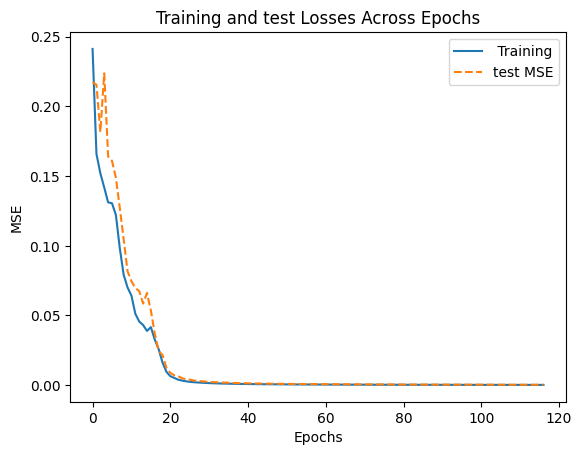

117


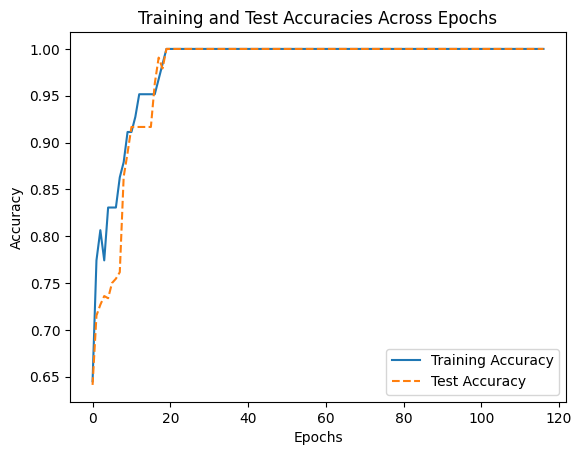

Refit Time: 8.10 seconds
Working with seed: 42
Starting epoch 1
0.23640829062572233
Starting epoch 2
0.23183352158715329
Starting epoch 3
0.2037078437688588
Starting epoch 4
0.19262255702159126
Starting epoch 5
0.17441929110187898
Starting epoch 6
0.21647567998324693
Starting epoch 7
0.1703187964610859
Starting epoch 8
0.15012813600414018
Starting epoch 9
0.11508248737232794
Starting epoch 10
0.0762220097957214
Starting epoch 11
0.059588565510542445
Starting epoch 12
0.08599766070687177
Starting epoch 13
0.022953294961890032
Starting epoch 14
0.022030381420605677
Starting epoch 15
0.01940575222424404
Starting epoch 16
0.01999646710181777
Starting epoch 17
0.01991970278107113
Starting epoch 18
0.016001499107881467
Starting epoch 19
0.01697660135687329
Starting epoch 20
0.016240023697954947
Starting epoch 21
0.015833339493299178
Starting epoch 22
0.01669021277646405
Starting epoch 23
0.014548948697429969
Starting epoch 24
0.014683837961288023
Starting epoch 25
0.013684685860493186
Starti

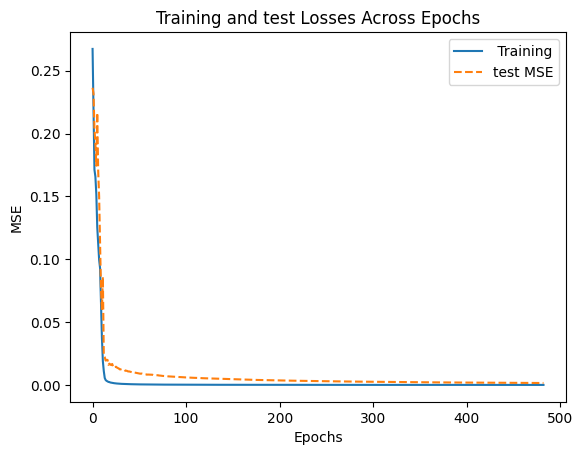

483


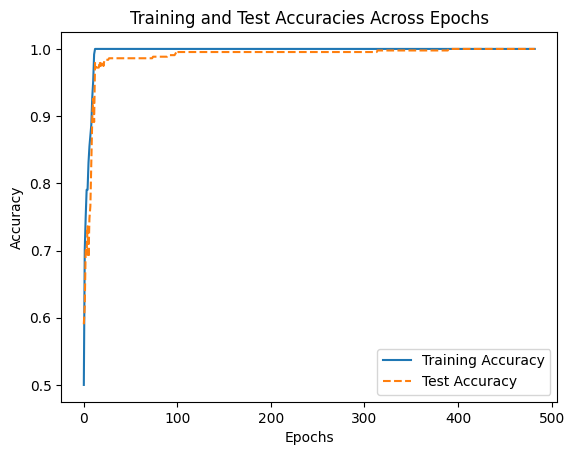

Refit Time: 34.73 seconds
Working with seed: 43
Starting epoch 1
0.2198063906075226
Starting epoch 2
0.19457811438823464
Starting epoch 3
0.24834301213613125
Starting epoch 4
0.1424403144693416
Starting epoch 5
0.10934121900208993
Starting epoch 6
0.059683401400602805
Starting epoch 7
0.04051887473475223
Starting epoch 8
0.034800758849828355
Starting epoch 9
0.022164352686053865
Starting epoch 10
0.01443250104694016
Starting epoch 11
0.012402483633060776
Starting epoch 12
0.014214147407175106
Starting epoch 13
0.013483856286964309
Starting epoch 14
0.01048131677318317
Starting epoch 15
0.010465112060753907
Starting epoch 16
0.009268005856399584
Starting epoch 17
0.008526021004568233
Starting epoch 18
0.008664967467430633
Starting epoch 19
0.008096404980329276
Starting epoch 20
0.007599237128656737
Starting epoch 21
0.006896531695693503
Starting epoch 22
0.006714377259211485
Starting epoch 23
0.006416201049837077
Starting epoch 24
0.006473407413539934
Starting epoch 25
0.006120840567207

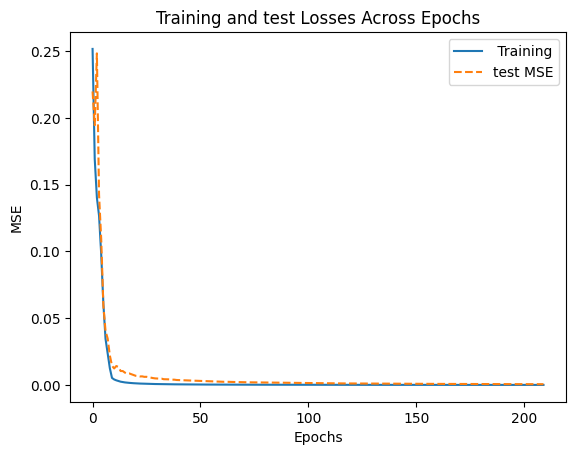

210


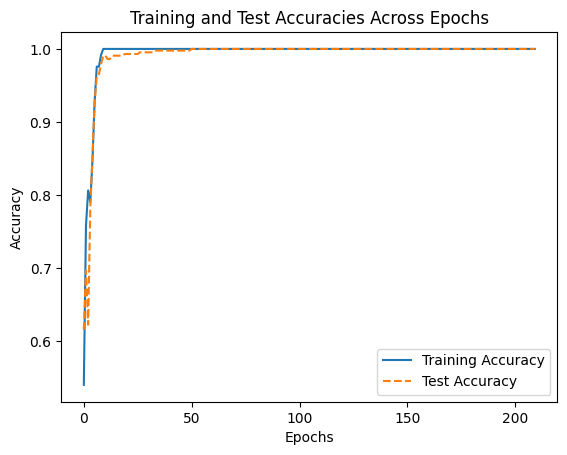

Refit Time: 14.10 seconds
Working with seed: 44
Starting epoch 1
0.26840546396043563
Starting epoch 2
0.2424440835516348
Starting epoch 3
0.19514697774623832
Starting epoch 4
0.18612279719673097
Starting epoch 5
0.17456594585544533
Starting epoch 6
0.16112282416886753
Starting epoch 7
0.13600937052009007
Starting epoch 8
0.11008785612001601
Starting epoch 9
0.09946190341401638
Starting epoch 10
0.08292441263674172
Starting epoch 11
0.077654307652025
Starting epoch 12
0.07324743325847925
Starting epoch 13
0.07075884914256339
Starting epoch 14
0.07183210472835021
Starting epoch 15
0.0672971305170062
Starting epoch 16
0.06549921852894369
Starting epoch 17
0.0631869559422032
Starting epoch 18
0.056411694588691545
Starting epoch 19
0.06357942653394949
Starting epoch 20
0.0490483674875577
Starting epoch 21
0.04904906739035074
Starting epoch 22
0.04024310632303241
Starting epoch 23
0.016486264966564097
Starting epoch 24
0.013030605791338358
Starting epoch 25
0.007728580277924064
Starting epoc

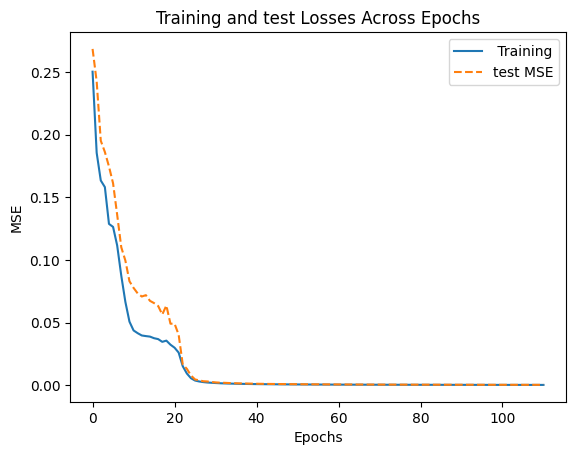

111


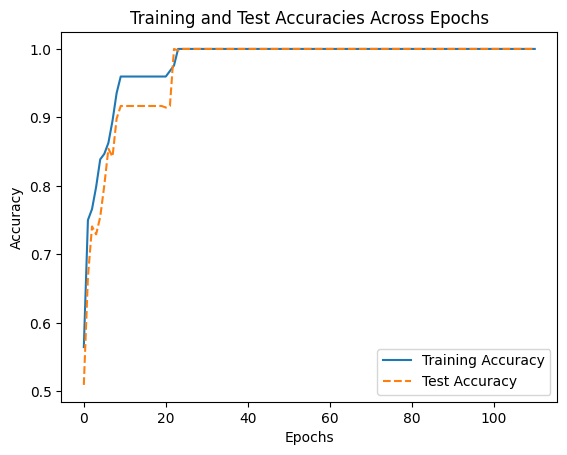

Refit Time: 8.09 seconds
Working with seed: 45
Starting epoch 1
0.2824218226251779
Starting epoch 2
0.20975908892298187
Starting epoch 3
0.2191376421014192
Starting epoch 4
0.17489594113323148
Starting epoch 5
0.22710770039163805
Starting epoch 6
0.1577421481617623
Starting epoch 7
0.14034642581612355
Starting epoch 8
0.13238837947116094
Starting epoch 9
0.13813054455035687
Starting epoch 10
0.11881834038002934
Starting epoch 11
0.1312257398902956
Starting epoch 12
0.1010633669966073
Starting epoch 13
0.06358018415523004
Starting epoch 14
0.0427524334744602
Starting epoch 15
0.016016430750217598
Starting epoch 16
0.010156495998402263
Starting epoch 17
0.007265526798113974
Starting epoch 18
0.0055642666934377135
Starting epoch 19
0.004531486535496596
Starting epoch 20
0.004180756018926062
Starting epoch 21
0.0038343991539780595
Starting epoch 22
0.0031338026993007924
Starting epoch 23
0.0027492648664014675
Starting epoch 24
0.002613162937955672
Starting epoch 25
0.002419963778568975
Sta

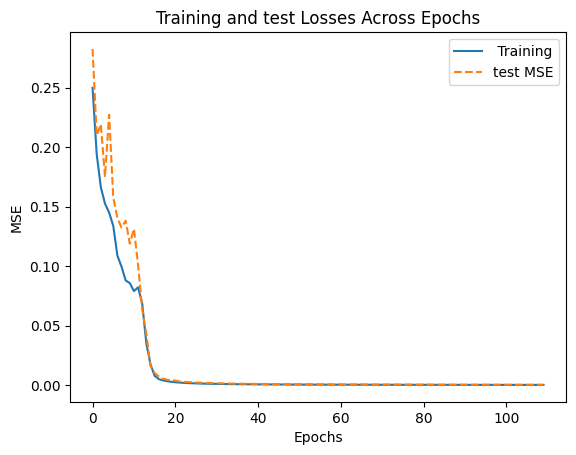

110


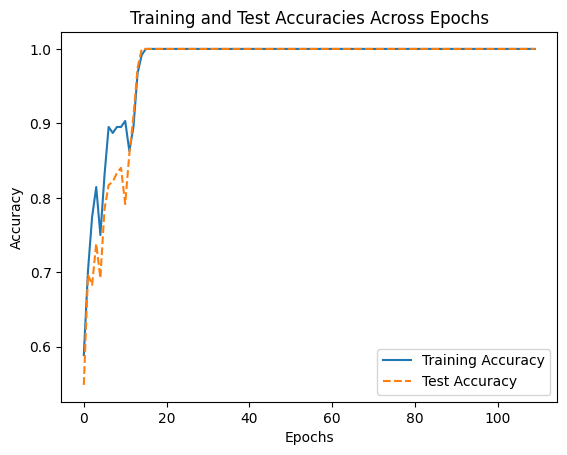

Refit Time: 7.84 seconds
TRAIN MEAN MSE 0.00013725530157515057
TRAIN STD 6.012131238573283e-05
TEST MEAN MSE 0.0005473139030879054
TEST STD 0.00047108553583834217


In [479]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params,seeds=SEEDS)  



accuracy on test set 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       216

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



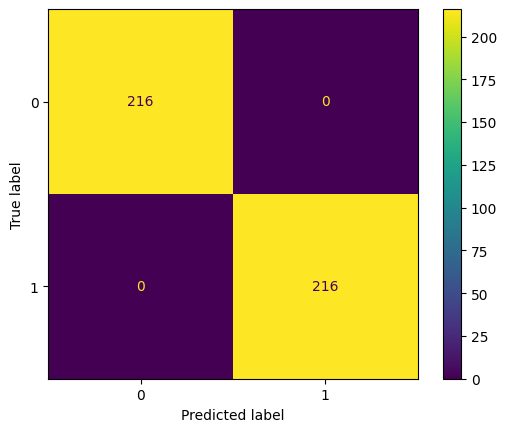

------------------------------------------------------------------------------------------------------


In [437]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")


MONK 2

Actual iter 0.0%
Working with seed: 42
Early stopping: 99
Early stopping: 129
Early stopping: 96
Early stopping: 125
Early stopping: 90
5


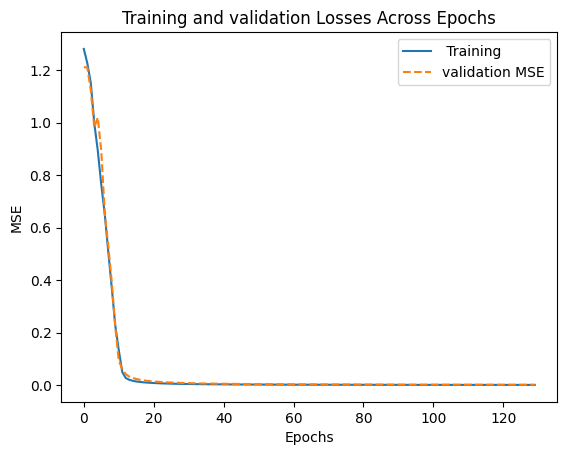

TRAIN MEAN MSE 0.0008219946359836752
TRAIN STD 0.0
VALIDATION MEAN MSE 0.00028345718797845787
VALIDATION STD 0.0


In [438]:
input_size = 17  
output_size = 1
params_grid_general = {
    "hidden_size": [3, 4, 5],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0,0.001,0.01],
    "momentum": [0],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],

}


params_grid = {
    "hidden_size": [4],
    "learning_rate": [0.8],
    "batch_size": [4],
    "weight_decay": [0],
    "momentum": [0.5],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],


}
    

dataset_train_part = read_ds(TR_PATH_2)
dataset_test_part = read_ds(TS_PATH_2)

dataset = dataset_train_part

best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size,seeds = [SEED])
        




In [439]:
#Best parameters found
print(f"Best hidden size: {best_params[5]} \nBest learning rate: {best_params[2]} \nBest batch size: {best_params[9]} \nBest weight decay: {best_params[8]} \nBest momentum: {best_params[6]}")

print(best_params)

Best hidden size: 4 
Best learning rate: 0.8 
Best batch size: 4 
Best weight decay: 0 
Best momentum: 0.5
(0.00028345718797845787, 0.0008219946359836752, 0.8, 600, MSELoss(), 4, 0.5, <class 'torch.optim.sgd.SGD'>, 0, 4)


Working with seed: 40
Starting epoch 1
0.24359202931669574
Starting epoch 2
0.23240822746797843
Starting epoch 3
0.21856694689227474
Starting epoch 4
0.22134009284760664
Starting epoch 5
0.2236952453299805
Starting epoch 6
0.17054128615375333
Starting epoch 7
0.14427712739065843
Starting epoch 8
0.06191747113027506
Starting epoch 9
0.027557028634301213
Starting epoch 10
0.008299866607153995
Starting epoch 11
0.005619850931301092
Starting epoch 12
0.0042673669554965776
Starting epoch 13
0.00333978181286646
Starting epoch 14
0.0027454153955827846
Starting epoch 15
0.0023492277708741043
Starting epoch 16
0.002122245878800405
Starting epoch 17
0.001834947084447507
Starting epoch 18
0.001636752863608611
Starting epoch 19
0.0014603793935276809
Starting epoch 20
0.0013409201974691652
Starting epoch 21
0.0012303506960894015
Starting epoch 22
0.0011370851829673888
Starting epoch 23
0.001057394729286898
Starting epoch 24
0.0009859512507251497
Starting epoch 25
0.0009260169837809237
Starting epoc

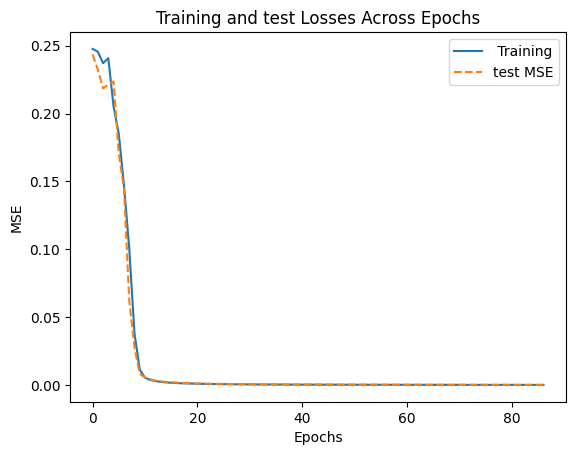

87


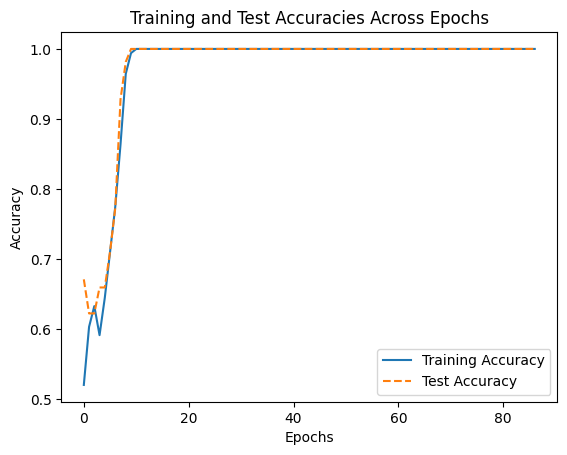

Working with seed: 41
Starting epoch 1
0.28293588040051637
Starting epoch 2
0.2271539813114537
Starting epoch 3
0.253537453159138
Starting epoch 4
0.22453609741016947
Starting epoch 5
0.2013074134528223
Starting epoch 6
0.21785747372390082
Starting epoch 7
0.026978435714867105
Starting epoch 8
0.011206687352602818
Starting epoch 9
0.0073745103673664505
Starting epoch 10
0.0051832475259693134
Starting epoch 11
0.004251649528871187
Starting epoch 12
0.003488929368797
Starting epoch 13
0.0029330971506338014
Starting epoch 14
0.002521411381571347
Starting epoch 15
0.002302793715864903
Starting epoch 16
0.0020746492181960667
Starting epoch 17
0.001882938126477206
Starting epoch 18
0.0017062965327770347
Starting epoch 19
0.0015898867749018354
Starting epoch 20
0.001469297600797964
Starting epoch 21
0.001386659941393494
Starting epoch 22
0.0013093226163484225
Starting epoch 23
0.0012327070222387124
Starting epoch 24
0.0011484924727011713
Starting epoch 25
0.001093557088299551
Starting epoch 2

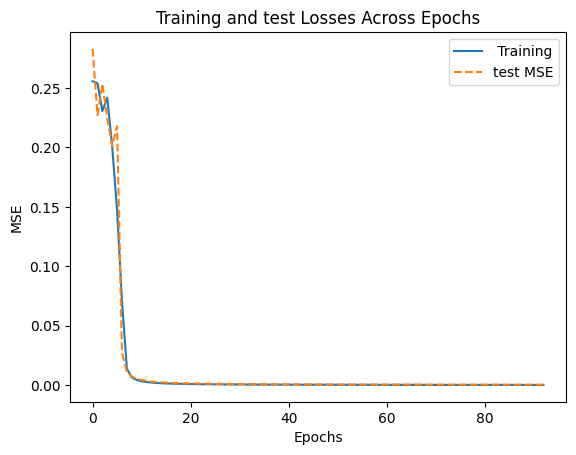

93


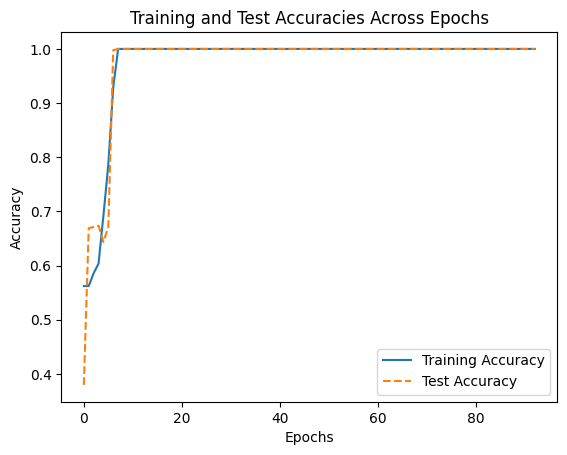

Working with seed: 42
Starting epoch 1
0.24959671869874
Starting epoch 2
0.24710211237133653
Starting epoch 3
0.22127041710471665
Starting epoch 4
0.23698506890623658
Starting epoch 5
0.21436391225843518
Starting epoch 6
0.18632150099923214
Starting epoch 7
0.15388192170885978
Starting epoch 8
0.12361061397112078
Starting epoch 9
0.0878753912240629
Starting epoch 10
0.03728470077988243
Starting epoch 11
0.01309604239779421
Starting epoch 12
0.007308740401640534
Starting epoch 13
0.004954433528904768
Starting epoch 14
0.0038643085518506944
Starting epoch 15
0.0030535350109588493
Starting epoch 16
0.0025858853473942466
Starting epoch 17
0.002288629863027449
Starting epoch 18
0.0019269654097755578
Starting epoch 19
0.0017279719433173778
Starting epoch 20
0.0015320567822696089
Starting epoch 21
0.0014090999625127384
Starting epoch 22
0.0012802108427018134
Starting epoch 23
0.0011800182969805232
Starting epoch 24
0.0010969053659613968
Starting epoch 25
0.001027102079307143
Starting epoch 26

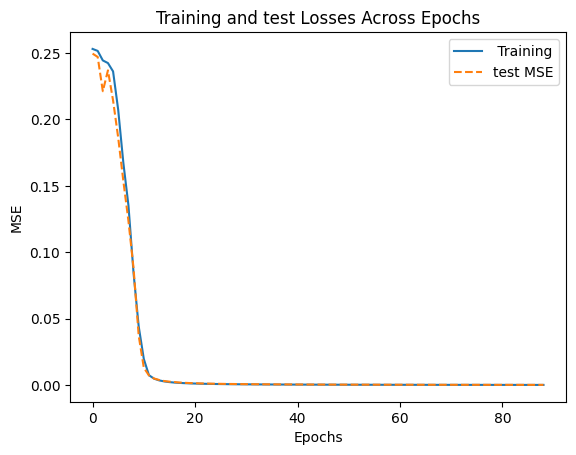

89


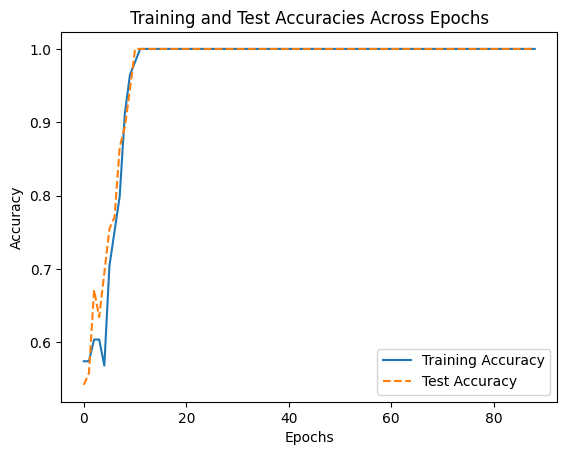

Working with seed: 43
Starting epoch 1
0.23702427896636505
Starting epoch 2
0.23595421512921652
Starting epoch 3
0.24806607569809314
Starting epoch 4
0.23678887918315553
Starting epoch 5
0.21789417298579658
Starting epoch 6
0.18408390514000697
Starting epoch 7
0.1655106254038401
Starting epoch 8
0.1314283233843054
Starting epoch 9
0.09266170213447401
Starting epoch 10
0.03421354859515473
Starting epoch 11
0.020120141281815315
Starting epoch 12
0.0071495694056567215
Starting epoch 13
0.005432626252985318
Starting epoch 14
0.004013983600695307
Starting epoch 15
0.0035316765435574643
Starting epoch 16
0.002762799023508301
Starting epoch 17
0.0024745396453740628
Starting epoch 18
0.0020696607540163247
Starting epoch 19
0.001843965616933053
Starting epoch 20
0.0016738399316198883
Starting epoch 21
0.0015481999747593094
Starting epoch 22
0.0013971061645726742
Starting epoch 23
0.0013224175878955673
Starting epoch 24
0.0012150272781986536
Starting epoch 25
0.0011186447057601374
Starting epoch

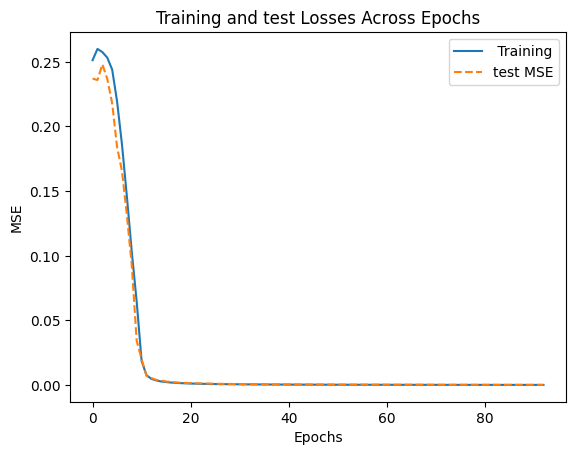

93


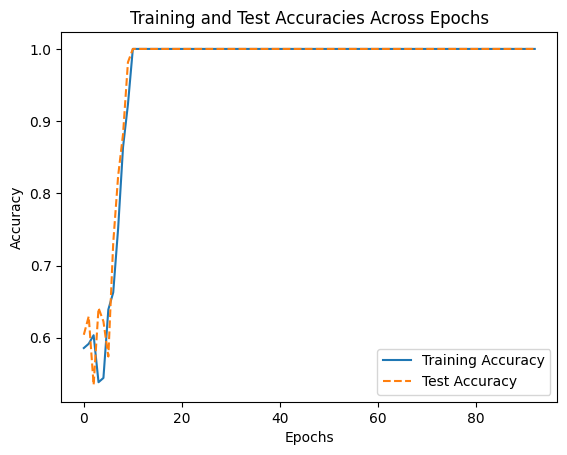

Working with seed: 44
Starting epoch 1
0.2365192445684914
Starting epoch 2
0.2230692089845737
Starting epoch 3
0.2241018364826838
Starting epoch 4
0.23458265126855285
Starting epoch 5
0.2889718696199082
Starting epoch 6
0.22768385570358346
Starting epoch 7
0.23144487267429079
Starting epoch 8
0.20484796156071955
Starting epoch 9
0.19728651411693404
Starting epoch 10
0.19106631405237648
Starting epoch 11
0.16778079104713267
Starting epoch 12
0.16262714964708452
Starting epoch 13
0.16820406901684623
Starting epoch 14
0.1415377032417045
Starting epoch 15
0.1647752485824404
Starting epoch 16
0.150299201583645
Starting epoch 17
0.1550994696121456
Starting epoch 18
0.17164316065868157
Starting epoch 19
0.13117590034757828
Starting epoch 20
0.13543579638240366
Starting epoch 21
0.16162282889874607
Starting epoch 22
0.13862260608773255
Starting epoch 23
0.1584928987408434
Starting epoch 24
0.1536576303604104
Starting epoch 25
0.14645704675920704
Starting epoch 26
0.1474314747514048
Starting ep

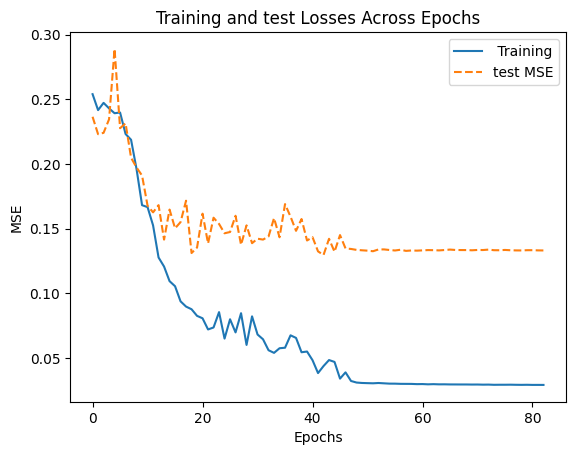

83


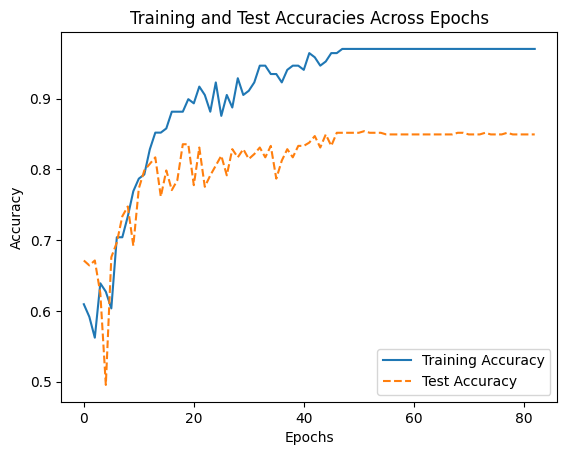

Working with seed: 45
Starting epoch 1
0.22508474177232496
Starting epoch 2
0.20873716328707007
Starting epoch 3
0.18698217499035377
Starting epoch 4
0.16195671084440416
Starting epoch 5
0.14609650966573368
Starting epoch 6
0.07437823270663137
Starting epoch 7
0.027324545093708567
Starting epoch 8
0.013769267590423287
Starting epoch 9
0.007440060463354543
Starting epoch 10
0.005123704213743891
Starting epoch 11
0.0040345828456338495
Starting epoch 12
0.0033923927990987
Starting epoch 13
0.0028365994221530855
Starting epoch 14
0.002502649381683484
Starting epoch 15
0.002052594724874426
Starting epoch 16
0.0018854584063605958
Starting epoch 17
0.0016381078926820515
Starting epoch 18
0.001501347453018685
Starting epoch 19
0.0014099153855500776
Starting epoch 20
0.0012906088204881936
Starting epoch 21
0.0011742806277147287
Starting epoch 22
0.0011088256123238588
Starting epoch 23
0.001030895209287
Starting epoch 24
0.000976239545842098
Starting epoch 25
0.0009129697322754913
Starting epoch

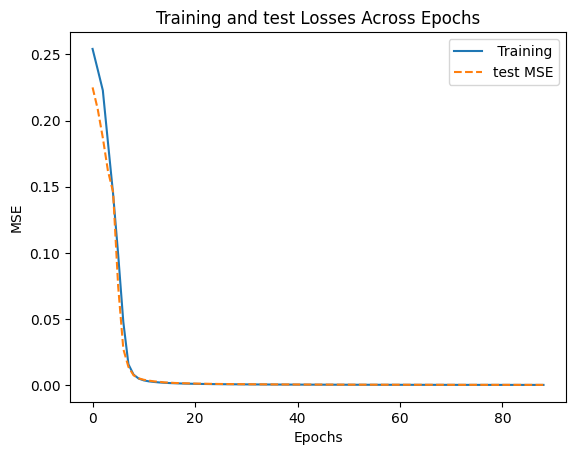

89


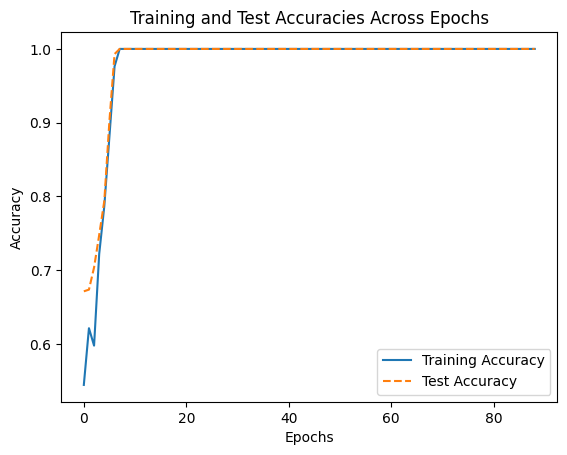

TRAIN MEAN MSE 0.0049870803406853945
TRAIN STD 0.010839474671093067
TEST MEAN MSE 0.022359537964702112
TEST STD 0.04955790914551131


TypeError: cannot unpack non-iterable Net object

In [442]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params,seeds=SEEDS)  


accuracy on test set 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       1.00      1.00      1.00       142

    accuracy                           1.00       432
   macro avg       1.00      1.00      1.00       432
weighted avg       1.00      1.00      1.00       432



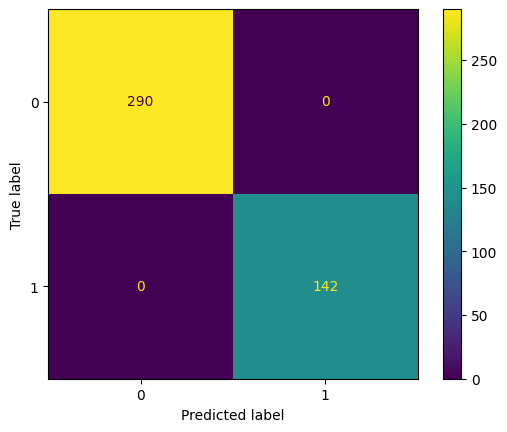

------------------------------------------------------------------------------------------------------


In [ ]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")


MONK 3

Actual iter 0.0%
Early stopping: 164
Early stopping: 201
Early stopping: 199
Early stopping: 146
Early stopping: 183
5


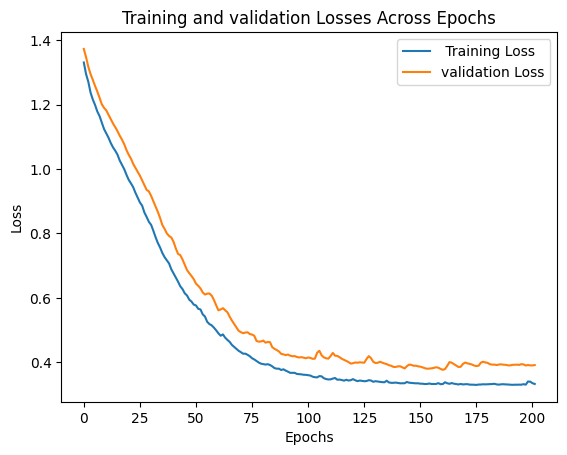

In [ ]:
input_size = 17  
output_size = 1
'''params_grid_u = {
    "hidden_size": [3, 4, 5],
    "learning_rate": [0.1,0.4,0.7,0.8],
    "batch_size": [4,8,12,32],
    "weight_decay": [0.0001,0.02,0.001,0.1,0.2],
    "momentum": [0,0.1,0.4,0.7,0.8],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
}


params_grid_sp = {
    "hidden_size": [4,5],
    "learning_rate": [0.1, 0.05, 0.2],
    "batch_size": [16,32],
    "weight_decay": [0.01,0.1,0.2],
    "momentum": [0.4, 0.01, 0.05, 0.1],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
}
'''
params_grid = {
    "hidden_size": [4],
    "learning_rate": [0.1],
    "batch_size": [32],
    "weight_decay": [0.01],
    "momentum": [0.4],
    "epochs":[600],
    "optimizer":[torch.optim.SGD],
}

dataset_train_part = read_ds(TR_PATH_3)
dataset_test_part = read_ds(TS_PATH_3)

dataset = dataset_train_part
best_params = dogridsearch(dataset_train_part=dataset_train_part,params_grid=params_grid,output_size=output_size,input_size=input_size,seeds = [SEED])


In [ ]:
#Best parameters found
print(f"Best hidden size: {best_params[5]} \nBest learning rate: {best_params[2]} \nBest batch size: {best_params[9]} \nBest weight decay: {best_params[8]} \nBest momentum: {best_params[6]}")

print(best_params)

Best hidden size: 4 
Best learning rate: 0.1 
Best batch size: 32 
Best weight decay: 0.01 
Best momentum: 0.4
(0.07824624553322793, 0.3325725261579714, 0.1, 600, MSELoss(), 4, 0.4, <class 'torch.optim.sgd.SGD'>, 0.01, 32)


Starting epoch 1
0.3319376872645484
Starting epoch 2
0.31018082411200915
Starting epoch 3
0.2885453469223446
Starting epoch 4
0.2696467395182009
Starting epoch 5
0.25671209891637164
Starting epoch 6
0.2459810784569493
Starting epoch 7
0.23789254051667671
Starting epoch 8
0.2311699859522007
Starting epoch 9
0.226724480037336
Starting epoch 10
0.22275791786335133
Starting epoch 11
0.21925054600945226
Starting epoch 12
0.21641917085206067
Starting epoch 13
0.21364875027426966
Starting epoch 14
0.2109909305969874
Starting epoch 15
0.2082507891787423
Starting epoch 16
0.20540936401596777
Starting epoch 17
0.2024689852087586
Starting epoch 18
0.19965845732777207
Starting epoch 19
0.19699834452735054
Starting epoch 20
0.19417874018351236
Starting epoch 21
0.1913958743766502
Starting epoch 22
0.18842486761234425
Starting epoch 23
0.18534519606166416
Starting epoch 24
0.18239873426931877
Starting epoch 25
0.17974332747636018
Starting epoch 26
0.1766763484036481
Starting epoch 27
0.1738823431509

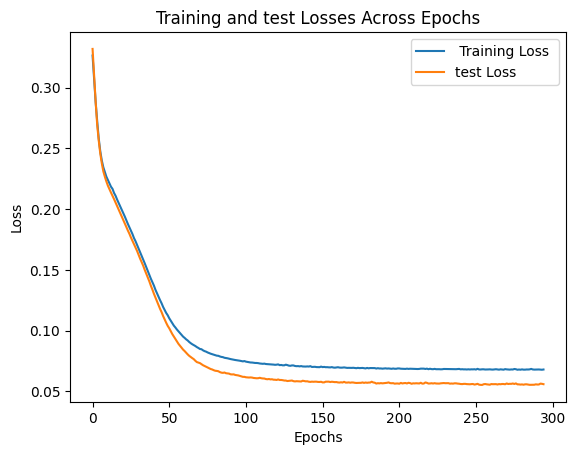

295
295
295


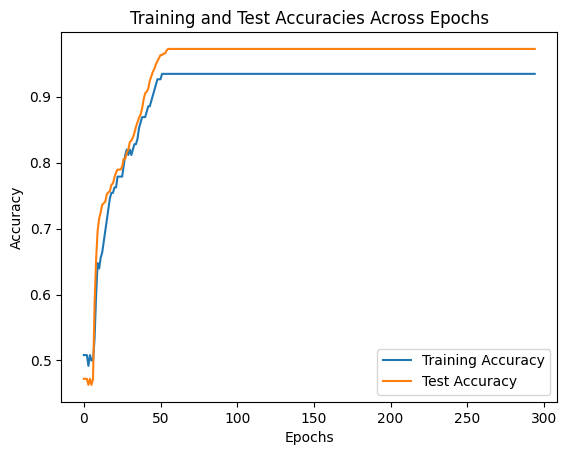

In [ ]:
best_net = train_test_model(dataset_train_part=dataset_train_part,dataset_test_part=dataset_test_part,best_params=best_params,seed=SEEDS)  

accuracy on test set 0.972
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       204
           1       1.00      0.95      0.97       228

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



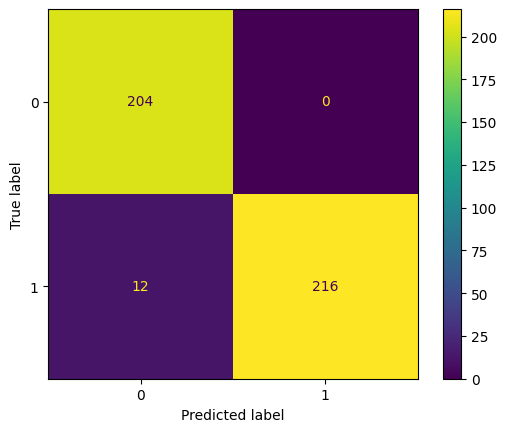

------------------------------------------------------------------------------------------------------


In [ ]:
test_data = torch.from_numpy(dataset_test_part[:, 1:]).to(torch.float32)
val_labels = torch.from_numpy(dataset_test_part[:, [0]]).to(torch.float32)

#Print accuracy on test set
test_outputs = best_net(test_data).round().int().view(-1)

y_pred = best_net(test_data)
y_pred = y_pred.round().int().view(-1)
print("accuracy on test set {:.3f}".format(accuracy_score( val_labels,y_pred)))
print(classification_report(val_labels, 
                            y_pred, 
                            target_names=['0', '1']))

#print the confusion matrix
cm = confusion_matrix(val_labels, test_outputs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
print("------------------------------------------------------------------------------------------------------")
